In [1]:
#!pip install konlpy
import pandas as pd
import numpy as np
from konlpy.tag import Kkma
from konlpy.utils import pprint
from konlpy.tag import Komoran
from konlpy.tag import Okt
import warnings
import seaborn as sns
warnings.filterwarnings(action = 'ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk import bigrams
import itertools

import networkx as nx

from konlpy.tag import Hannanum
from ckonlpy.tag import Postprocessor
from ckonlpy.tag import Twitter
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
# 폰트 한글 설정

from matplotlib import font_manager, rc
font_path = 'C:\\Windows\\Fonts\\malgun.ttf' # 경로 설정을 제대로 해야함
font_name= font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

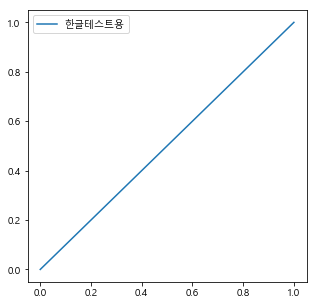

In [3]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

In [4]:
bedal=pd.read_excel('C:/Users/USER/Dropbox (kk-bigdata)/0.Workspace/DG/김동규_Spyder/bedal.xlsx')
bedal.head()

,date,content,delivery,keyword
0,201905,자가제빵 선명희 피자 평내호평점 \n피맥카페에 배달피자할인까지~!!\n 자가제빵...,배달,카페
1,201905,운영시간\n매일 10 : 00 - 21 : 00\n연중무휴 나는 다이어트하느라고 요...,배달,카페
2,201905,이번주 날씨가 오후엔 30도가 육박하고 벌써부터 너무 더운거 아닌가요~\n무더위가 ...,배달,카페
3,201905,여러분 안녕 미니예요!!\n오늘 날이 너무 좋아요~ㅠㅠ\n또 피크닉 가고 싶고 그래...,배달,카페
4,201905,"구미, 배달가능한 카페가 있어요 : )\n저도, 이번에 배달의민족을 보다가 알았어요...",배달,카페


In [5]:
nobedal = pd.read_excel('C:/Users/USER/Dropbox (kk-bigdata)/0.Workspace/DG/김동규_Spyder/nobedal.xlsx')
nobedal.head()

,date,content,delivery,keyword
0,201905,파주 카페 / 더티트렁크 - 엄청난 규모의 파주 핫플레이스\n안녕하세요 몽몽이에요\...,NO배달,카페
1,201905,"지난주 주말, 친구가 새로 생긴 카페라고\n가보고싶다고 해서 \n수서카페, 식물관 ...",NO배달,카페
2,201905,제주도 3박4일\nㅋㅋ 국수마당에서 밥먹구 이제 카페 가야지이~\n제주도 봄 하면 ...,NO배달,카페
3,201905,"안성에서 부모님과 식사를 하고 나면(주로 소나무향기에서), 두가지를 고민하게 된다....",NO배달,카페
4,201905,예전부터 너무 잘 어울린다고 생각하고 있는\n오상진 김소영 전 아나운서 부부\n특히...,NO배달,카페


In [6]:
df=pd.concat([bedal,nobedal])
df.sort_values('date').reset_index(drop=True,inplace=True)
df.head()

,date,content,delivery,keyword
0,201905,자가제빵 선명희 피자 평내호평점 \n피맥카페에 배달피자할인까지~!!\n 자가제빵...,배달,카페
1,201905,운영시간\n매일 10 : 00 - 21 : 00\n연중무휴 나는 다이어트하느라고 요...,배달,카페
2,201905,이번주 날씨가 오후엔 30도가 육박하고 벌써부터 너무 더운거 아닌가요~\n무더위가 ...,배달,카페
3,201905,여러분 안녕 미니예요!!\n오늘 날이 너무 좋아요~ㅠㅠ\n또 피크닉 가고 싶고 그래...,배달,카페
4,201905,"구미, 배달가능한 카페가 있어요 : )\n저도, 이번에 배달의민족을 보다가 알았어요...",배달,카페


# Data Preprocessing
- 우선 명사(한글자 이상)만 추출하자. -> Konply 라이브러리 사용
- content 변수의 unique 값만 추출하여 단어 백터를 만들자

In [7]:
df.dropna(inplace=True)

konlpy tag 성능비교
- https://m.blog.naver.com/PostView.nhnblogId=wideeyed&logNo=221337575742&proxyReferer=https:%2F%2Fwww.google.com%2F

In [8]:
f = open("C:/Users/USER/Dropbox (kk-bigdata)/0.Workspace/DG/김동규_Spyder/koreanStopwords.txt", 'r',encoding='utf-8')
lines = f.readlines()
stopwords = []
for line in lines:
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()

stopwords= stopwords + ['카페','베스킨라빈스','배스킨라빈스','메뉴','커피','디저트','주문','어서','어요','배달','민족','예전',
                        '면서','하나','어가','까지','바로','정말','파리','바게뜨','천원','요기','영업','정말','파리','바게뜨','오늘']

In [9]:
kkma = Kkma()
komoran = Komoran()
okt = Okt()
hannanum = Hannanum()
tagger=Twitter()
#df['words'] = df['content'].apply(lambda x: okt.nouns(x))
postprocessor = Postprocessor(okt,passtags = 'Noun', stopwords = stopwords) 
df['words'] = df['content'].apply(lambda x: postprocessor.pos(x))

In [10]:
# 품사단위(단어,'Noun')는 빼고 단어만 받게 처리
df['words'] = df['words'].apply(lambda x: [i[0] for i in x]) 

In [11]:
df.head()

,date,content,delivery,keyword,words
0,201905,자가제빵 선명희 피자 평내호평점 \n피맥카페에 배달피자할인까지~!!\n 자가제빵...,배달,카페,"[자가, 제빵, 선명, 피자, 평내, 호, 평점, 피, 맥카페, 피자, 할인, 자가..."
1,201905,운영시간\n매일 10 : 00 - 21 : 00\n연중무휴 나는 다이어트하느라고 요...,배달,카페,"[운영, 매일, 연중, 무, 다이어트, 요즘, 점심, 항상, 외식, 과일, 계란, ..."
2,201905,이번주 날씨가 오후엔 30도가 육박하고 벌써부터 너무 더운거 아닌가요~\n무더위가 ...,배달,카페,"[날씨, 오후, 도, 육박, 벌써, 무더위, 겨울, 건가, 옷, 답, 평일, 퇴근,..."
3,201905,여러분 안녕 미니예요!!\n오늘 날이 너무 좋아요~ㅠㅠ\n또 피크닉 가고 싶고 그래...,배달,카페,"[안녕, 미니, 날, 피크닉, 힝, 저번, 피크닉, 소개, 포장, 간, 토스트, 도..."
4,201905,"구미, 배달가능한 카페가 있어요 : )\n저도, 이번에 배달의민족을 보다가 알았어요...",배달,카페,"[구미, 캠핑, 고기만, 입안, 텁텁, 음료, 빙수, 젤, 검색, 라서, 믿음, 무..."


단어 한개 짜리는 없애주자.

In [12]:
# 함수
def del_word(li):
    new_li = []
    for w in li:
        if len(w)>=2:
            new_li.append(w)
    return new_li

df['words'] = df['words'].apply(lambda x: list(set(del_word(x))))

In [13]:
df['words'].head()

0    [고이, 재료, 배려, 브라운, 고소, 눈빛, 제공, 평내, 썸머, 무스, 떨기, ...
1    [점심, 순간, 근처, 길거리, 이드, 샌드위치, 매일, 시작, 아주, 서비스, 하...
2    [사장, 라이더, 배경, 셀카, 거기, 표현, 완전, 마련, 말로, 언른, 미리, ...
3    [사장, 런가, 마리, 핫케익, 셀카, 아웃, 배려, 이드, 테이크, 진절, 카카오...
4    [숟가락, 라서, 포장, 이제, 직접, 실컷, 믿음, 무료, 로라, 우유, 얼음, ...
Name: words, dtype: object

In [14]:
word_list=np.hstack(df['words'].values) 

---
코로나 변수 만들기

In [15]:
df.loc[df['date'].apply(lambda x: str(x)[:4])=='2019','corona']=0
df.loc[df['date'].apply(lambda x: str(x)[:4])=='2020','corona']=1


---
워드 클라우드

(-0.5, 399.5, 199.5, -0.5)

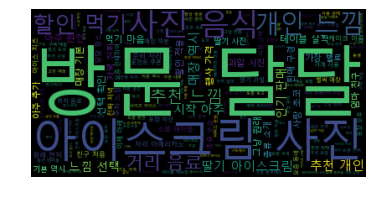

In [16]:
wordcloud = WordCloud(font_path='C:\\Windows\\Fonts\\malgun.ttf',max_font_size=100).generate(' '.join(word_list))

# Display the generated image:
# the matplotlib way:

fig = plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

---

# Association Rule
- 월별 
- 월별 delivery별
- 월별 keyword별
- 월별 delivery,keyword별

In [17]:
## 블로그별로 겹치는 단어가 있기 때문에 한번 더 중복처리
#col_list = list(set(word_list))

In [18]:
#items = col_list

In [19]:
# encoded_vals = []
# #def custom():
# for index, row in enumerate(df['words']):
#     labels = {}
#     uncommons = list(set(col_list) - set(row))
#     commons = list(set(col_list).intersection(row))
#     for uc in uncommons:
#         labels[uc] = 0
#     for com in commons:
#         labels[com] = 1
#     encoded_vals.append(labels)
# encoded_vals[0]
# ohe_df = pd.DataFrame(encoded_vals)

In [20]:
# ohe_df.head()

In [21]:
# freq_items = apriori(ohe_df, min_support=0.07, use_colnames=True, verbose=1)
# freq_items.head()

In [22]:
# rules = association_rules(freq_items, metric="confidence", min_threshold=0.7)
# rules.head()

In [23]:
# plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
# plt.xlabel('support')
# plt.ylabel('confidence')
# plt.title('Support vs Confidence')
# plt.show()

In [24]:
# plt.scatter(rules['support'], rules['lift'], alpha=0.5)
# plt.xlabel('support')
# plt.ylabel('lift')
# plt.title('Support vs Lift')
# plt.show()

In [25]:
# fit = np.polyfit(rules['lift'], rules['confidence'], 1)
# fit_fn = np.poly1d(fit)
# plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
#          fit_fn(rules['lift']))
# plt.title('Lift vs Confidence')
# plt.show()

전체적인 연관규칙을 봤을 때는, 의미있는 keyword를 찾기가 힘들어 보임. 좀 더 세부적으로 뽑아봐야할 것으로 보인다.
- 함수 형태로 만들어서 핵심키워드 좀 뽑아봅시다.

---

date, delivery,keyword로 groupby를 할 수 있는 함수를 만들어 보자.

In [26]:
def dateorcorona_association(col,df,when,bedal,stopwords=stopwords):
    okt = Okt()
    # 그 외 삭제할 단어 추가
    stopwords= stopwords + ['베스킨라빈스','배스킨라빈스','던킨','던킨도넛','메뉴','주문','어서','어요','배달','민족','예전',
                            '면서','하나','어가','까지','바로','정말','파리','바게뜨','천원','요기','영업','정말','파리','바게뜨',
                            '오늘','자주','가면','결제','요즘','보고','그냥','자리','진짜','래서','가능','하니','타고','신기','이제',
                            '기요','미리','최소','수도','사용','던킨','가끔','가득','던킨도너츠','메뉴판','이드','사진', '음료', '분위기',
                            '느낌','인테리어','공간','작성','이드','쇼케이스','출시','가게','가기','가까이','대가','대비']

    pil = df[df[col]==when]
    pil = pil[pil['delivery']==bedal]
    postprocessor = Postprocessor(okt,passtags = 'Noun', stopwords = stopwords) 
    pil['words'] = pil['content'].apply(lambda x: postprocessor.pos(x))

    # 품사단위(단어,'Noun')는 빼고 단어만 받게 처리
    pil['words'] = pil['words'].apply(lambda x: [i[0] for i in x])

    #블로그내에 겹치는 단어 삭제
    pil['words'] = pil['words'].apply(lambda x: list(set(del_word(x))))
    
    word_list=np.hstack(pil['words'].values)
    
    # 블로그별로 겹치는 단어가 있기 때문에 한번 더 중복처리
    col_list = list(set(word_list))
    items = col_list
    
    encoded_vals = []
    #def custom():
    for index, row in enumerate(pil['words']):
        labels = {}
        uncommons = list(set(col_list) - set(row))
        commons = list(set(col_list).intersection(row))
        for uc in uncommons:
            labels[uc] = 0
        for com in commons:
            labels[com] = 1
        encoded_vals.append(labels)
    encoded_vals[0]
    ohe_df = pd.DataFrame(encoded_vals)
    return ohe_df

In [27]:
ohe_df=dateorcorona_association('date',df,202005,'NO배달',stopwords=stopwords)

In [28]:
freq_items = apriori(ohe_df, min_support=0.02, use_colnames=True, verbose=1)
freq_items.head()

Processing 20 combinations | Sampling itemset size 10


,support,itemsets
0,0.360313,(가격)
1,0.033943,(가구)
2,0.054830,(가루)
3,0.033943,(가방)
4,0.033943,(가성)


In [29]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.7)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(만석),(가격),0.026110,0.360313,0.020888,0.800000,2.220290,0.011480,3.198433
1,(서비스),(가격),0.036554,0.360313,0.026110,0.714286,1.982402,0.012939,2.238903
2,(선호),(가격),0.020888,0.360313,0.020888,1.000000,2.775362,0.013362,inf
3,(이정),(가격),0.028721,0.360313,0.020888,0.727273,2.018445,0.010539,2.345518
4,(진심),(가격),0.028721,0.360313,0.023499,0.818182,2.270751,0.013150,3.518277


In [30]:
rules['comb']=rules['antecedents'].apply(lambda x: list(x)) + rules['consequents'].apply(lambda x: list(x))

In [31]:
dff=rules[rules['comb'].apply(lambda x: len(x))==2]

In [32]:
G  = nx.Graph()
ar = (dff['comb']); G.add_edges_from(ar)

In [33]:
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])

In [34]:
nsize

array([0.00524932, 0.02125132, 0.00529268, 0.00312113, 0.00312113,
       0.00312113, 0.00312113, 0.00312113, 0.00312113, 0.00299026,
       0.01251247, 0.00995816, 0.00798994, 0.00297715, 0.04085575,
       0.00442738, 0.00838662, 0.00380448, 0.0374261 , 0.00380448,
       0.00831798, 0.01154951, 0.00321799, 0.00331711, 0.00634047,
       0.00331711, 0.00911213, 0.01159205, 0.00580172, 0.00617542,
       0.010112  , 0.00375744, 0.010112  , 0.00580172, 0.00375744,
       0.00375744, 0.00290539, 0.00582414, 0.00680073, 0.00326399,
       0.00312681, 0.00442738, 0.00838662, 0.00574713, 0.00574713,
       0.00442738, 0.00838662, 0.00376751, 0.0136656 , 0.00574713,
       0.00574713, 0.00442738, 0.00333539, 0.00872548, 0.00775253,
       0.00333539, 0.00310766, 0.01320293, 0.00581698, 0.00757526,
       0.01086336, 0.01257224, 0.00871288, 0.00581722, 0.00383011,
       0.00445834, 0.01052221, 0.00821855, 0.00594306, 0.00338779,
       0.00451177, 0.00709531, 0.00303362, 0.00310766, 0.00442

In [35]:
nsize = 2000 * (nsize - min(nsize)) / ( max(nsize)-min(nsize))

In [36]:
#pos = nx.spring_layout(G)
#pos = nx.spiral_layout(G)
#pos = nx.shell_layout(G)
pos = nx.kamada_kawai_layout(G)

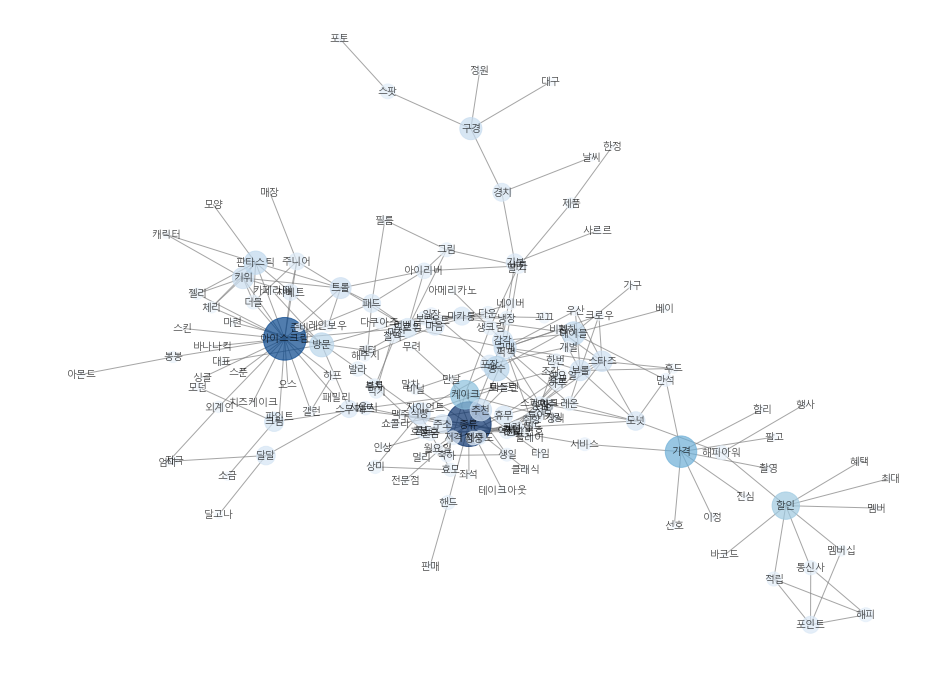

<Figure size 432x288 with 0 Axes>

In [37]:
plt.figure(figsize=(16,12));plt.axis('off')
nx.draw_networkx(G,font_family=font_name,font_size = 10,
                pos=pos,node_color=list(pr.values()),node_size=nsize,
                alpha=0.7,edge_color = '.5',cmap=plt.cm.Blues)
#nx.draw_networkx_labels(Gs[i],pos,Gs_label[i],font_family=font_name,font_size=10)

plt.show()
plt.savefig('C:/Users/USER/Dropbox (kk-bigdata)/0.Workspace/DG/김동규_Spyder/네트워크.png',bbox_inches='tight')